# Predicting the Outcome of Cricket Matches

## Introduction

In this project, we shall build a model which predicts the outcome of cricket matches in the Indian Premier League using data about matches and deliveries.

### Data Mining:

  * Season : 2008 - 2015 (8 Seasons)
  * Teams : DD, KKR, MI, RCB, KXIP, RR, CSK (7 Teams)
  * Neglect matches that have inconsistencies such as No Result, Tie, D/L Method, etc.

### Features:

  * Average Batsman Rating (Strike Rate)
  * Average Bowler Rating (Wickets per Run)
  * Player of the Match Awards in squad
  * Previous Encounters between two teams
  * Recent form (Last 3 games played)
  
### Prediction Model

  * K-Nearest Neighbors using sklearn
  * Gradient Boosting using xgboost
  
  

In [1]:
%matplotlib inline 
import numpy as np # imports a fast numerical programming library
import matplotlib.pyplot as plt #sets up plotting under plt
import pandas as pd #lets us handle data as dataframes
#sets up pandas table display
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
from __future__ import division

## Data Mining
  

In [2]:
# Reading in the data
allmatches = pd.read_csv("../data/matches.csv")
alldeliveries = pd.read_csv("../data/deliveries.csv")
allmatches.head(10)

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2008,Bangalore,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Kolkata Knight Riders,140,0,BB McCullum,M Chinnaswamy Stadium,Asad Rauf,RE Koertzen,NaN
1,2,2008,Chandigarh,2008-04-19,Chennai Super Kings,Kings XI Punjab,Chennai Super Kings,bat,normal,0,Chennai Super Kings,33,0,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",MR Benson,SL Shastri,NaN
2,3,2008,Delhi,2008-04-19,Rajasthan Royals,Delhi Daredevils,Rajasthan Royals,bat,normal,0,Delhi Daredevils,0,9,MF Maharoof,Feroz Shah Kotla,Aleem Dar,GA Pratapkumar,NaN
3,4,2008,Mumbai,2008-04-20,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,normal,0,Royal Challengers Bangalore,0,5,MV Boucher,Wankhede Stadium,SJ Davis,DJ Harper,NaN
4,5,2008,Kolkata,2008-04-20,Deccan Chargers,Kolkata Knight Riders,Deccan Chargers,bat,normal,0,Kolkata Knight Riders,0,5,DJ Hussey,Eden Gardens,BF Bowden,K Hariharan,NaN
5,6,2008,Jaipur,2008-04-21,Kings XI Punjab,Rajasthan Royals,Kings XI Punjab,bat,normal,0,Rajasthan Royals,0,6,SR Watson,Sawai Mansingh Stadium,Aleem Dar,RB Tiffin,NaN
6,7,2008,Hyderabad,2008-04-22,Deccan Chargers,Delhi Daredevils,Deccan Chargers,bat,normal,0,Delhi Daredevils,0,9,V Sehwag,"Rajiv Gandhi International Stadium, Uppal",IL Howell,AM Saheba,NaN
7,8,2008,Chennai,2008-04-23,Chennai Super Kings,Mumbai Indians,Mumbai Indians,field,normal,0,Chennai Super Kings,6,0,ML Hayden,"MA Chidambaram Stadium, Chepauk",DJ Harper,GA Pratapkumar,NaN
8,9,2008,Hyderabad,2008-04-24,Deccan Chargers,Rajasthan Royals,Rajasthan Royals,field,normal,0,Rajasthan Royals,0,3,YK Pathan,"Rajiv Gandhi International Stadium, Uppal",Asad Rauf,MR Benson,NaN
9,10,2008,Chandigarh,2008-04-25,Kings XI Punjab,Mumbai Indians,Mumbai Indians,field,normal,0,Kings XI Punjab,66,0,KC Sangakkara,"Punjab Cricket Association Stadium, Mohali",Aleem Dar,AM Saheba,NaN


In [3]:
# Selecting Seasons 2008 - 2015
matches_seasons = allmatches.loc[allmatches['season'] != 2016]
deliveries_seasons = alldeliveries.loc[alldeliveries['match_id'] < 518]

In [4]:
# Selecting teams DD, KKR, MI, RCB, KXIP, RR, CSK
matches_teams = matches_seasons.loc[(matches_seasons['team1'].isin(['Kolkata Knight Riders', \
'Royal Challengers Bangalore', 'Delhi Daredevils', 'Chennai Super Kings', 'Rajasthan Royals', \
'Mumbai Indians', 'Kings XI Punjab'])) & (matches_seasons['team2'].isin(['Kolkata Knight Riders', \
'Royal Challengers Bangalore', 'Delhi Daredevils', 'Chennai Super Kings', 'Rajasthan Royals', \
'Mumbai Indians', 'Kings XI Punjab']))]
matches_team_matchids = matches_teams.id.unique()
deliveries_teams = deliveries_seasons.loc[deliveries_seasons['match_id'].isin(matches_team_matchids)]
print "Teams selected:\n"
for team in matches_teams.team1.unique():
    print team

Teams selected:

Kolkata Knight Riders
Chennai Super Kings
Rajasthan Royals
Mumbai Indians
Kings XI Punjab
Royal Challengers Bangalore
Delhi Daredevils


In [5]:
# Neglect matches with inconsistencies like 'No Result' or 'D/L Applied'
matches = matches_teams.loc[(matches_teams['result'] == 'normal') & (matches_teams['dl_applied'] == 0)]
matches_matchids = matches.id.unique()
deliveries = deliveries_teams.loc[deliveries_teams['match_id'].isin(matches_matchids)]
# Verifying consistency between datasets
(matches.id.unique() == deliveries.match_id.unique()).all()

True

## Building Features

In [6]:
# Batsman Strike Rate Calculation (Top 5 Batsmen)
# Team 1: Batting First; Team 2: Fielding First

def getMatchDeliveriesDF(match_id):
    return deliveries.loc[deliveries['match_id'] == match_id]

def getInningsOneBatsmen(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 1].batsman.unique()[0:5]

def getInningsTwoBatsmen(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 2].batsman.unique()[0:5]

def getBatsmanStrikeRate(batsman, match_id):
    onstrikedeliveries = deliveries.loc[(deliveries['match_id'] < match_id) & (deliveries['batsman'] == batsman)]
    total_runs = onstrikedeliveries['batsman_runs'].sum()
    total_balls = onstrikedeliveries.shape[0]
    if total_balls != 0: 
        return (total_runs/total_balls) * 100
    else:
        return None

def getTeamStrikeRate(batsmen, match_id):
    strike_rates = []
    for batsman in batsmen:
        bsr = getBatsmanStrikeRate(batsman, match_id)
        if bsr != None:
            strike_rates.append(bsr)
    return np.mean(strike_rates)

def getAverageStrikeRates(match_id):
    match_deliveries = getMatchDeliveriesDF(match_id)
    innOneBatsmen = getInningsOneBatsmen(match_deliveries)
    innTwoBatsmen = getInningsTwoBatsmen(match_deliveries)
    teamOneSR = getTeamStrikeRate(innOneBatsmen, match_id)
    teamTwoSR = getTeamStrikeRate(innTwoBatsmen, match_id)
    return teamOneSR, teamTwoSR

In [7]:
# testing functionality
getAverageStrikeRates(517)

(126.98024523159935, 128.55579510411653)

In [8]:
# Bowler Rating : Wickets/Run (Higher the Better)
# Team 1: Batting First; Team 2: Fielding First

def getInningsOneBowlers(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 1].bowler.unique()[0:4]

def getInningsTwoBowlers(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 2].bowler.unique()[0:4]

def getBowlerWPR(bowler, match_id):
    balls = deliveries.loc[(deliveries['match_id'] < match_id) & (deliveries['bowler'] == bowler)]
    total_runs = balls['total_runs'].sum()
    total_wickets = balls.loc[balls['dismissal_kind'].isin(['caught', 'bowled', 'lbw', \
    'caught and bowled', 'stumped'])].shape[0]
    if balls.shape[0] > 0:
        return (total_wickets/total_runs) * 100
    else:
        return None

def getTeamWPR(bowlers, match_id):
    WPRs = []
    for bowler in bowlers:
        bwpr = getBowlerWPR(bowler, match_id)
        if bwpr != None:
            WPRs.append(bwpr)
    return np.mean(WPRs)

def getAverageWPR(match_id):
    match_deliveries = getMatchDeliveriesDF(match_id)
    innOneBowlers = getInningsOneBowlers(match_deliveries)
    innTwoBowlers = getInningsTwoBowlers(match_deliveries)
    teamOneWPR = getTeamWPR(innTwoBowlers, match_id)
    teamTwoWPR = getTeamWPR(innOneBowlers, match_id)
    return teamOneWPR, teamTwoWPR

In [9]:
# testing functionality
getAverageWPR(517)

(2.7641806594085776, 4.4721111768026631)

In [10]:
# MVP Score (Total number of Player of the Match awards in a squad)
# Team 1: Batting First; Team 2: Fielding First

def getAllInningsOneBatsmen(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 1].batsman.unique()

def getAllInningsTwoBatsmen(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 2].batsman.unique()

def getAllInningsOneBowlers(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 1].bowler.unique()

def getAllInningsTwoBowlers(match_deliveries):
    return match_deliveries.loc[match_deliveries['inning'] == 2].bowler.unique()

def makeSquad(batsmen, bowlers):
    p = []
    p = np.append(p, batsmen)
    for i in bowlers:
        if i not in batsmen:
            p = np.append(p, i)
    return p

def getPlayerMVPAwards(player, match_id):
    return matches.loc[(matches['player_of_match'] == player) & (matches['id'] < match_id)].shape[0]

def getTeamMVPAwards(squad, match_id):
    num_awards = 0
    for player in squad:
        num_awards += getPlayerMVPAwards(player, match_id)
    return num_awards

def compareMVPAwards(match_id):
    match_deliveries = getMatchDeliveriesDF(match_id)
    innOneBatsmen = getAllInningsOneBatsmen(match_deliveries)
    innTwoBatsmen = getAllInningsTwoBatsmen(match_deliveries)
    innOneBowlers = getAllInningsOneBowlers(match_deliveries)
    innTwoBowlers = getAllInningsTwoBowlers(match_deliveries)
    teamOneSquad = makeSquad(innOneBatsmen, innTwoBowlers)
    teamTwoSquad = makeSquad(innTwoBatsmen, innOneBowlers)
    teamOneAwards = getTeamMVPAwards(teamOneSquad, match_id)
    teamTwoAwards = getTeamMVPAwards(teamTwoSquad, match_id)
    return teamOneAwards, teamTwoAwards

In [11]:
compareMVPAwards(517)

(28, 52)

In [12]:
# Prints a comparison between two teams based on squad attributes
def generateSquadRating(match_id):
    gameday_teams = deliveries.loc[(deliveries['match_id'] == match_id)].batting_team.unique()
    teamOne = gameday_teams[0]
    teamTwo = gameday_teams[1]
    teamOneSR, teamTwoSR = getAverageStrikeRates(match_id)
    teamOneWPR, teamTwoWPR = getAverageWPR(match_id)
    teamOneMVPs, teamTwoMVPs = compareMVPAwards(match_id)
    print "Comparing squads for " + teamOne + " vs " + teamTwo
    print "\nAverage Strike Rate for Batsmen in " + str(teamOne) + " : " + str(teamOneSR)
    print "\nAverage Strike Rate for Batsmen in " + str(teamTwo) + " : " + str(teamTwoSR)
    print "\nBowler Rating for " + str(teamOne) + " : " + str(teamOneWPR)
    print "\nBowler Rating for " + str(teamTwo) + " : " + str(teamTwoWPR)
    print "\nNumber of MVP Awards in " + str(teamOne) + " : " + str(teamOneMVPs)
    print "\nNumber of MVP Awards in " + str(teamTwo) + " : " + str(teamTwoMVPs)

In [13]:
generateSquadRating(517)

Comparing squads for Mumbai Indians vs Chennai Super Kings

Average Strike Rate for Batsmen in Mumbai Indians : 126.980245232

Average Strike Rate for Batsmen in Chennai Super Kings : 128.555795104

Bowler Rating for Mumbai Indians : 2.76418065941

Bowler Rating for Chennai Super Kings : 4.4721111768

Number of MVP Awards in Mumbai Indians : 28

Number of MVP Awards in Chennai Super Kings : 52


In [14]:
# Previous Encounters (All games played in previous matches)
# Win % for Team 1 against Team 2

def getTeam1(match_id):
    return matches.loc[matches["id"] == match_id].team1.unique()

def getTeam2(match_id):
    return matches.loc[matches["id"] == match_id].team2.unique()

def getPreviousEncDF(match_id):
    team1 = getTeam1(match_id)
    team2 = getTeam2(match_id)
    return matches.loc[(matches["id"] < match_id) & (((matches["team1"].isin(team1)) & (matches["team2"].isin(team2))) | ((matches["team1"].isin(team2)) & (matches["team2"].isin(team1))))]

def getTeamWBR(match_id, team):
    WBR = 0
    DF = getPreviousEncDF(match_id)
    winnerDF = DF.loc[DF["winner"] == team]
    WBR = winnerDF['win_by_runs'].sum()    
    return WBR


def getTeamWBW(match_id, team):
    WBW = 0 
    DF = getPreviousEncDF(match_id)
    winnerDF = DF.loc[DF["winner"] == team]
    WBW = winnerDF['win_by_wickets'].sum()
    return WBW 
    
def getTeamWinPerc(match_id):
    dF = getPreviousEncDF(match_id)
    timesPlayed = dF.shape[0]
    team1 = getTeam1(match_id)[0].strip("[]")
    timesWon = dF.loc[dF["winner"] == team1].shape[0]
    if timesPlayed != 0:
        winPerc = (timesWon/timesPlayed) * 100
    else:
        winPerc = 0
    return winPerc

def getBothTeamStats(match_id):
    DF = getPreviousEncDF(match_id)
    team1 = getTeam1(match_id)[0].strip("[]")
    team2 = getTeam2(match_id)[0].strip("[]")
    timesPlayed = DF.shape[0]
    timesWon = DF.loc[DF["winner"] == team1].shape[0]
    WBRTeam1 = getTeamWBR(match_id, team1)
    WBRTeam2 = getTeamWBR(match_id, team2)
    WBWTeam1 = getTeamWBW(match_id, team1)
    WBWTeam2 = getTeamWBW(match_id, team2)

    print "Out of {} times in the past {} have won {} times({}%) from {}".format(timesPlayed, team1, timesWon, getTeamWinPerc(match_id), team2)
    print "{} won by {} total runs and {} total wickets.".format(team1, WBRTeam1, WBWTeam1)
    print "{} won by {} total runs and {} total wickets.".format(team2, WBRTeam2, WBWTeam2)


In [15]:
#Testing functionality 
getBothTeamStats(517)

Out of 21 times in the past Mumbai Indians have won 11 times(52.380952381%) from Chennai Super Kings
Mumbai Indians won by 144 total runs and 30 total wickets.
Chennai Super Kings won by 138 total runs and 31 total wickets.


In [16]:
# Recent Form (Win Percentage of the 3 previous matches of a team in the same season)
# Higher the better

def getMatchYear(match_id):
    return matches.loc[matches["id"] == match_id].season.unique()

def getTeam1DF(match_id, year):
    team1 = getTeam1(match_id)
    return matches.loc[(matches["id"] < match_id) & (matches["season"] == year) & ((matches["team1"].isin(team1)) | (matches["team2"].isin(team1)))].tail(3)

def getTeam2DF(match_id, year):
    team2 = getTeam2(match_id)
    return matches.loc[(matches["id"] < match_id) & (matches["season"] == year) & ((matches["team1"].isin(team2)) | (matches["team2"].isin(team2)))].tail(3)

def getTeamWinPercentage(match_id):
    year = int(getMatchYear(match_id))
    team1 = getTeam1(match_id)[0].strip("[]")
    team2 = getTeam2(match_id)[0].strip("[]")
    team1DF = getTeam1DF(match_id, year)
    team2DF = getTeam2DF(match_id, year)
    team1TotalMatches = team1DF.shape[0]
    team1WinMatches = team1DF.loc[team1DF["winner"] == team1].shape[0]
    team2TotalMatches = team2DF.shape[0]
    team2WinMatches = team2DF.loc[team2DF["winner"] == team2].shape[0]
    if (team1TotalMatches != 0) and (team2TotalMatches !=0):
        winPercTeam1 = ((team1WinMatches / team1TotalMatches) * 100) 
        winPercTeam2 = ((team2WinMatches / team2TotalMatches) * 100) 
    elif (team1TotalMatches != 0) and (team2TotalMatches ==0):
        winPercTeam1 = ((team1WinMatches / team1TotalMatches) * 100) 
        winPercTeam2 = 0
    elif (team1TotalMatches == 0) and (team2TotalMatches !=0):
        winPercTeam1 = 0
        winPercTeam2 = ((team2WinMatches / team2TotalMatches) * 100) 
    else:
        winPercTeam1 = 0
        winPercTeam2 = 0
    return winPercTeam1, winPercTeam2

In [17]:
getTeamWinPercentage(517)

(66.66666666666666, 66.66666666666666)

In [18]:
#Function to implement all features
def getAllFeatures(match_id):
    generateSquadRating(match_id)
    print ("\n")
    getBothTeamStats(match_id)
    print("\n")
    getTeamWinPercentage(match_id)


In [19]:
#Testing Functionality
getAllFeatures(517)

Comparing squads for Mumbai Indians vs Chennai Super Kings

Average Strike Rate for Batsmen in Mumbai Indians : 126.980245232

Average Strike Rate for Batsmen in Chennai Super Kings : 128.555795104

Bowler Rating for Mumbai Indians : 2.76418065941

Bowler Rating for Chennai Super Kings : 4.4721111768

Number of MVP Awards in Mumbai Indians : 28

Number of MVP Awards in Chennai Super Kings : 52


Out of 21 times in the past Mumbai Indians have won 11 times(52.380952381%) from Chennai Super Kings
Mumbai Indians won by 144 total runs and 30 total wickets.
Chennai Super Kings won by 138 total runs and 31 total wickets.




## Adding New Columns for Features in Matches DataFrame

In [20]:
# New Column for Difference of Average Strike rates (First Team SR - Second Team SR) 
# [Negative value means Second team is better]

firstTeamSR = []
secondTeamSR = []
for i in matches['id'].unique():
    P, Q = getAverageStrikeRates(i)
    firstTeamSR.append(P), secondTeamSR.append(Q)
firstSRSeries = pd.Series(firstTeamSR)
secondSRSeries = pd.Series(secondTeamSR)
matches["Avg_SR_Difference"] = firstSRSeries.values - secondSRSeries.values 

/home/soham/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/soham/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/soham/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [21]:
# New Column for Difference of Wickets Per Run (First Team WPR - Second Team WPR) 
# [Negative value means Second team is better]

firstTeamWPR = []
secondTeamWPR = []
for i in matches['id'].unique():
    R, S = getAverageWPR(i)
    firstTeamWPR.append(R), secondTeamWPR.append(S)
firstWPRSeries = pd.Series(firstTeamWPR)
secondWPRSeries = pd.Series(secondTeamWPR)
matches["Avg_WPR_Difference"] = firstWPRSeries.values - secondWPRSeries.values 

/home/soham/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [22]:
# New column for difference of MVP Awards 
# (Negative value means Second team is better)

firstTeamMVP = []
secondTeamMVP = []
for i in matches['id'].unique():
    T, U = compareMVPAwards(i)
    firstTeamMVP.append(T), secondTeamMVP.append(U)
firstMVPSeries = pd.Series(firstTeamMVP)
secondMVPSeries = pd.Series(secondTeamMVP)
matches["Total_MVP_Difference"] = firstMVPSeries.values - secondMVPSeries.values 

/home/soham/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [23]:
# New column for Win Percentage of Team 1 in previous encounters

firstTeamWP = []
for i in matches['id'].unique():
    WP = getTeamWinPerc(i)
    firstTeamWP.append(WP)
firstWPSeries = pd.Series(firstTeamWP)
matches["Prev_Enc_Team1_WinPerc"] = firstWPSeries.values

/home/soham/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [24]:
# New column for Recent form(Win Percentage in the current season) of 1st Team compared to 2nd Team
# (Negative means 2nd team has higher win percentage)

firstTeamRF = []
secondTeamRF = []
for i in matches['id'].unique():
    K, L = getTeamWinPercentage(i)
    firstTeamRF.append(K), secondTeamRF.append(L)
firstRFSeries = pd.Series(firstTeamRF)
secondRFSeries = pd.Series(secondTeamRF)
matches["Total_RF_Difference"] = firstRFSeries.values - secondRFSeries.values 

/home/soham/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [25]:
#Create Column for Team 1 Winning Status (1 = Won, 0 = Lost)

matches['team1Winning'] = np.where(matches['team1'] == matches['winner'], 1, 0)

/home/soham/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [26]:
#Testing 
matches

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3,Avg_SR_Difference,Avg_WPR_Difference,Total_MVP_Difference,Prev_Enc_Team1_WinPerc,Total_RF_Difference,team1Winning
0,1,2008,Bangalore,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Kolkata Knight Riders,140,0,BB McCullum,M Chinnaswamy Stadium,Asad Rauf,RE Koertzen,NaN,NaN,NaN,0,0.000000,0.000000,1
1,2,2008,Chandigarh,2008-04-19,Chennai Super Kings,Kings XI Punjab,Chennai Super Kings,bat,normal,0,Chennai Super Kings,33,0,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",MR Benson,SL Shastri,NaN,NaN,NaN,0,0.000000,0.000000,1
2,3,2008,Delhi,2008-04-19,Rajasthan Royals,Delhi Daredevils,Rajasthan Royals,bat,normal,0,Delhi Daredevils,0,9,MF Maharoof,Feroz Shah Kotla,Aleem Dar,GA Pratapkumar,NaN,NaN,NaN,0,0.000000,0.000000,0
3,4,2008,Mumbai,2008-04-20,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,normal,0,Royal Challengers Bangalore,0,5,MV Boucher,Wankhede Stadium,SJ Davis,DJ Harper,NaN,NaN,NaN,0,0.000000,0.000000,0
5,6,2008,Jaipur,2008-04-21,Kings XI Punjab,Rajasthan Royals,Kings XI Punjab,bat,normal,0,Rajasthan Royals,0,6,SR Watson,Sawai Mansingh Stadium,Aleem Dar,RB Tiffin,NaN,55.665975,1.414786,0,0.000000,0.000000,0
7,8,2008,Chennai,2008-04-23,Chennai Super Kings,Mumbai Indians,Mumbai Indians,field,normal,0,Chennai Super Kings,6,0,ML Hayden,"MA Chidambaram Stadium, Chepauk",DJ Harper,GA Pratapkumar,NaN,6.135734,-1.591368,1,0.000000,100.000000,1
9,10,2008,Chandigarh,2008-04-25,Kings XI Punjab,Mumbai Indians,Mumbai Indians,field,normal,0,Kings XI Punjab,66,0,KC Sangakkara,"Punjab Cricket Association Stadium, Mohali",Aleem Dar,AM Saheba,NaN,4.666844,0.111379,0,0.000000,0.000000,1
10,11,2008,Bangalore,2008-04-26,Royal Challengers Bangalore,Rajasthan Royals,Rajasthan Royals,field,normal,0,Rajasthan Royals,0,7,SR Watson,M Chinnaswamy Stadium,MR Benson,IL Howell,NaN,25.388743,-0.021123,0,0.000000,0.000000,0
11,12,2008,Chennai,2008-04-26,Kolkata Knight Riders,Chennai Super Kings,Kolkata Knight Riders,bat,normal,0,Chennai Super Kings,0,9,JDP Oram,"MA Chidambaram Stadium, Chepauk",BF Bowden,AV Jayaprakash,NaN,-28.438618,11.723738,0,0.000000,0.000000,0
13,14,2008,Chandigarh,2008-04-27,Delhi Daredevils,Kings XI Punjab,Delhi Daredevils,bat,normal,0,Kings XI Punjab,0,4,SM Katich,"Punjab Cricket Association Stadium, Mohali",RE Koertzen,I Shivram,NaN,41.221731,6.066625,0,0.000000,66.666667,0


## Visualizations for Features vs. Response

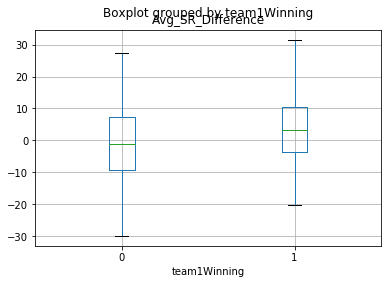

In [27]:
matches.boxplot(column = 'Avg_SR_Difference', by='team1Winning', showfliers= False)

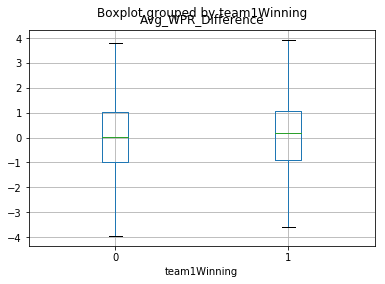

In [28]:
matches.boxplot(column = 'Avg_WPR_Difference', by='team1Winning', showfliers= False)

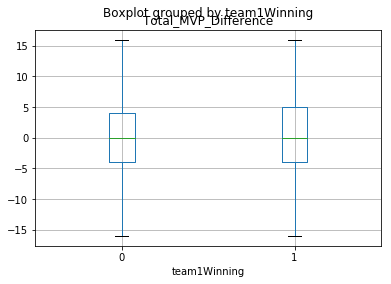

In [29]:
matches.boxplot(column = 'Total_MVP_Difference', by='team1Winning', showfliers= False)

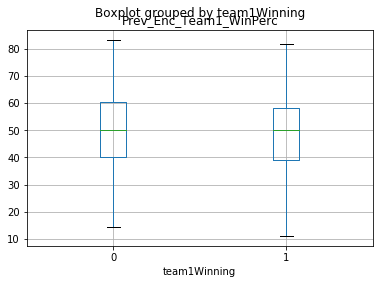

In [30]:
matches.boxplot(column = 'Prev_Enc_Team1_WinPerc', by='team1Winning', showfliers= False)

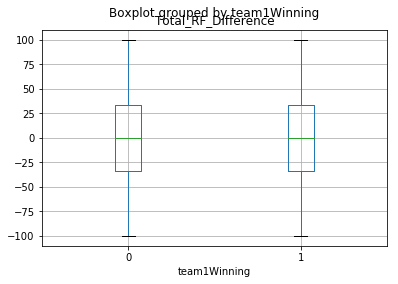

In [31]:
matches.boxplot(column = 'Total_RF_Difference', by='team1Winning', showfliers= False)

## Predictions

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from patsy import dmatrices

/home/soham/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [33]:
y, X = dmatrices('team1Winning ~ 0 + Avg_SR_Difference + Avg_WPR_Difference + Total_MVP_Difference + Prev_Enc_Team1_WinPerc + \
                  Total_RF_Difference', matches, return_type="dataframe")
y_arr = np.ravel(y)

### Training and Testing on Entire Data

In [34]:
# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(X, y_arr)
# check the accuracy on the training set
print "Accuracy is", model.score(X, y_arr)*100, "%"

Accuracy is 57.4923547401 %


### Splitting train and test using train_test_split

In [35]:
# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_arr, random_state = 0)

In [36]:
# Logistic Regression on train_test_split
model2 = LogisticRegression()
model2.fit(X_train, y_train)
# predict class labels for the test set
predicted = model2.predict(X_test)
# generate evaluation metrics
print "Accuracy is ", metrics.accuracy_score(y_test, predicted)*100, "%"

Accuracy is  58.5365853659 %


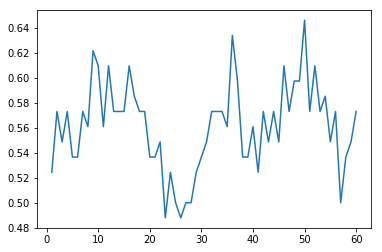

In [37]:
# KNN Classification on train_test_split
k_range = list(range(1, 61))
k_score = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    k_score.append(metrics.accuracy_score(y_test, y_pred))
plt.plot(k_range, k_score)

In [38]:
# Best values of k in train_test_split
knn = KNeighborsClassifier(n_neighbors = 50)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print "Accuracy is ", metrics.accuracy_score(y_test, y_pred)*100, "%" 

Accuracy is  64.6341463415 %


### Splitting Training Set (2008-2013) and Test Set (2013-2015) based on Seasons

In [39]:
X_timetrain = X.loc[X.index < 398]
Y_timetrain = y.loc[y.index < 398]
Y_timetrain_arr = np.ravel(Y_timetrain)
X_timetest = X.loc[X.index >= 398]
Y_timetest = y.loc[y.index >= 398]
Y_timetest_arr = np.ravel(Y_timetest)
X_timetest

,Avg_SR_Difference,Avg_WPR_Difference,Total_MVP_Difference,Prev_Enc_Team1_WinPerc,Total_RF_Difference
398,-9.646646,0.466526,6.0,16.666667,0.000000
399,4.963605,0.097800,12.0,50.000000,0.000000
400,7.079810,0.432566,11.0,70.000000,0.000000
402,21.485599,1.176414,17.0,53.846154,-100.000000
403,-4.503334,1.663169,15.0,54.545455,100.000000
404,-7.297630,-0.332117,-1.0,72.727273,-100.000000
405,12.183316,2.316918,5.0,66.666667,-50.000000
407,-5.341707,2.620287,12.0,61.538462,50.000000
408,5.093091,0.588349,20.0,54.545455,-50.000000
410,-13.668459,-2.328697,0.0,60.000000,-66.666667


In [40]:
# Logistic Regression on time-based split sets
model3 = LogisticRegression()
model3.fit(X_timetrain, Y_timetrain_arr)
timepredicted = model3.predict(X_timetest)
print "Accuracy is ", metrics.accuracy_score(Y_timetest_arr, timepredicted)*100, "%"

Accuracy is  52.8735632184 %


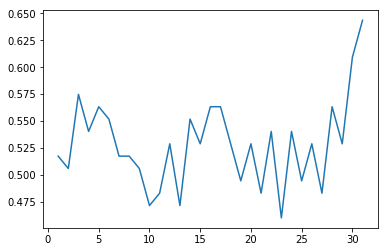

In [53]:
# KNN Classification on time-based split sets
k_range = list(range(1, 32))
k_score = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_timetrain, Y_timetrain_arr)
    y_pred = knn.predict(X_timetest)
    k_score.append(metrics.accuracy_score(Y_timetest_arr, y_pred))
plt.plot(k_range, k_score)  

In [54]:
# Best values of k in time-based split data
knn1 = KNeighborsClassifier(n_neighbors = 31)
knn1.fit(X_timetrain, Y_timetrain_arr)
y_pred = knn1.predict(X_timetest)
print "Accuracy is ", metrics.accuracy_score(Y_timetest_arr, y_pred)*100, "%"

Accuracy is  64.367816092 %


### Support Vector Machines

In [43]:
clf = svm.SVC(gamma=0.001, C=10)
clf.fit(X_timetrain, Y_timetrain_arr)
clf_pred = clf.predict(X_timetest)
print "Accuracy is ", metrics.accuracy_score(Y_timetest_arr, clf_pred)*100, "%"

Accuracy is  45.9770114943 %


### Random Forests

In [44]:
rfc = RandomForestClassifier(n_jobs = -1, random_state = 1)
rfc.fit(X_timetrain, Y_timetrain_arr)
rfc_pred = rfc.predict(X_timetest)
print "Accuracy is ", metrics.accuracy_score(Y_timetest_arr, rfc_pred)*100, "%"

Accuracy is  54.0229885057 %


In [45]:
fi = zip(X.columns, rfc.feature_importances_)
print "Feature Importance according to Random Forests Model\n"
for i in fi:
    print i[0], ":", i[1]

Feature Importance according to Random Forests Model

Avg_SR_Difference : 0.330684992918
Avg_WPR_Difference : 0.21317276792
Total_MVP_Difference : 0.191778034092
Prev_Enc_Team1_WinPerc : 0.141146504197
Total_RF_Difference : 0.123217700874


### Naive Bayes Classifier

In [46]:
gclf = GaussianNB()
gclf.fit(X_timetrain, Y_timetrain_arr)
gclf_pred = gclf.predict(X_timetest)
print "Accuracy is ", metrics.accuracy_score(Y_timetest_arr, gclf_pred) *100, "%"

Accuracy is  55.1724137931 %


### Cross Validation

In [47]:
from sklearn.cross_validation import cross_val_score

In [48]:
rfc = LogisticRegression()
scores = cross_val_score(rfc, X, y_arr, cv=10, scoring='accuracy')
scores

array([ 0.48484848,  0.57575758,  0.60606061,  0.48484848,  0.51515152,
        0.66666667,  0.48484848,  0.45454545,  0.5       ,  0.41935484])

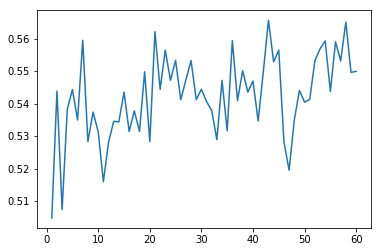

In [49]:
k_range = list(range(1, 61))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y_arr, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
plt.plot(k_range, k_scores)

### Gradient Boosting

In [50]:
from xgboost import XGBClassifier

In [51]:
xgbtest = XGBClassifier(
     learning_rate =1,
     n_estimators=2,
     max_depth=6,
     min_child_weight=8,
     gamma=0.1,
     subsample=0.9,
     colsample_bytree=0.8,
     objective= 'binary:logistic',
     scale_pos_weight=1,
     seed=27)
xgbtest.fit(X_timetrain, Y_timetrain_arr)
xgbtest_pred = xgbtest.predict(X_timetest)
print "Accuracy is ", metrics.accuracy_score(Y_timetest_arr, xgbtest_pred) *100, "%"

Accuracy is  62.0689655172 %


# Get Prediction for Web App

In [55]:
def getPrediction(match_id):
    '''Returns the prediction for the given match
    
    Args: match_id (int): Match ID for the required game
    
    Returns: String: Predicted winner of the game and probability of victory 
    '''
    results = {}
    match_row = matches.loc[matches['id'] == match_id]
    team1name = match_row.team1.unique()[0]
    team2name = match_row.team2.unique()[0]
    toPredict = X_timetest.loc[X_timetest.index == match_id-1].values
    prediction_prob = knn1.predict_proba(toPredict)
    prediction = knn1.predict(toPredict)
    if prediction[0] > 0:
        results['name'] = str(team1name)
        results['prob'] = float(prediction_prob[0][1])*100
    else:
        results['name'] = str(team2name)
        results['prob'] = float(prediction_prob[0][0])*100
    return results

getPrediction(517)

{'name': 'Mumbai Indians', 'prob': 51.61290322580645}